# PSF Matching Kernels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

from mophongo.psf_map import PSFRegionMap
import mophongo.psf
importlib.reload(mophongo.psf)
from mophongo.psf import DrizzlePSF, PSF
from mophongo.kernels import KernelLookup
from astropy.io import fits




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## Build the PSF region map

PA CLASS None
PA CLASS {(np.str_('jw01837001001_08201_00001_nrcalong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001001_08201_00001_nrcblong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001001_08201_00002_nrcalong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001001_08201_00002_nrcblong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001002_08201_00001_nrcalong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001002_08201_00001_nrcblong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001002_08201_00002_nrcalong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001002_08201_00002_nrcblong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001003_08201_00001_nrcalong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001003_08201_00001_nrcblong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001003_08201_00002_nrcalong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001003_08201_00002_nrcblong_rate.fits'), np.int64(1)): 110, (np.str_('jw01837001004_08201_00001_nrcalong_rate.fi

(    psf_key                                           geometry  \
 0         0  POLYGON ((34.29933 -5.19794, 34.27033 -5.20806...   
 1         1  POLYGON ((34.29933 -5.19744, 34.29094 -5.17456...   
 2         2  POLYGON ((34.29483 -5.16972, 34.29017 -5.17133...   
 3         3  POLYGON ((34.27944 -5.12639, 34.27928 -5.12589...   
 4         4  POLYGON ((34.27839 -5.13839, 34.28311 -5.13661...   
 5         5  POLYGON ((34.28311 -5.13661, 34.27839 -5.13839...   
 6         6  POLYGON ((34.27878 -5.12372, 34.274 -5.12539, ...   
 7         7  POLYGON ((34.27828 -5.13844, 34.27839 -5.13839...   
 8         8  POLYGON ((34.27811 -5.1385, 34.27828 -5.13844,...   
 9         9  POLYGON ((34.27828 -5.13844, 34.27811 -5.138, ...   
 10       10  POLYGON ((34.28272 -5.15161, 34.25417 -5.16161...   
 11       11  POLYGON ((34.32056 -5.14967, 34.32067 -5.14961...   
 12       12  POLYGON ((34.28333 -5.136, 34.27989 -5.12672, ...   
 13       13  POLYGON ((34.28311 -5.13661, 34.2835 -5.13644,..

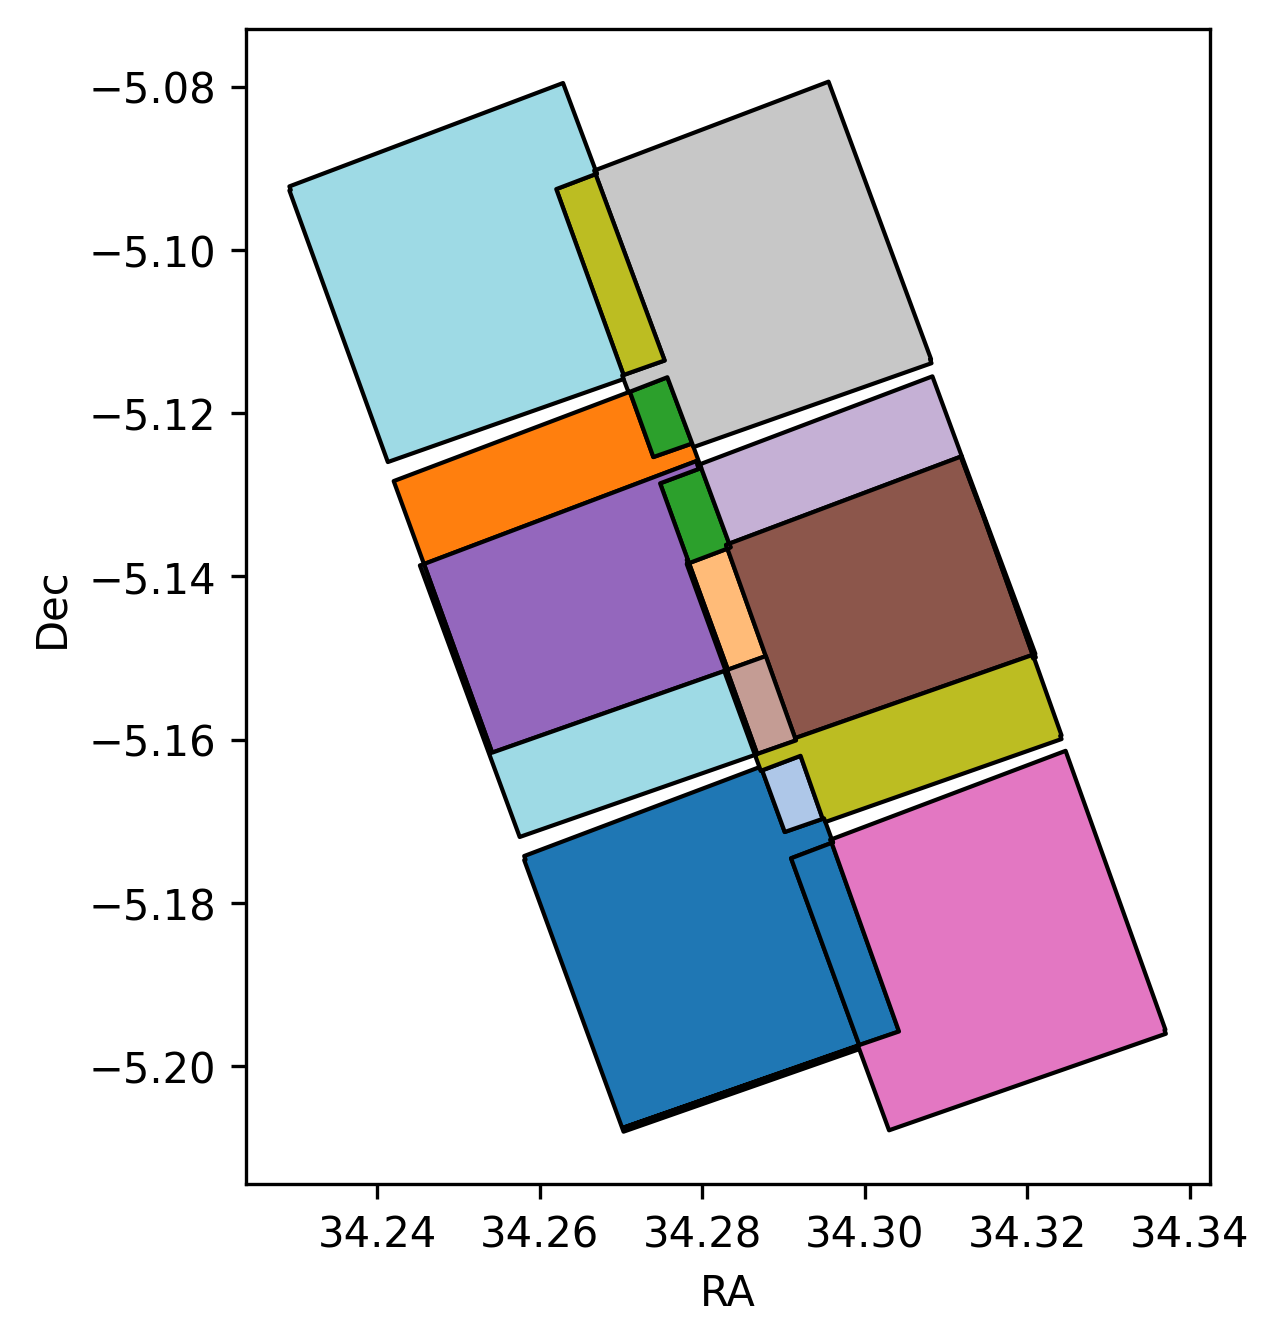

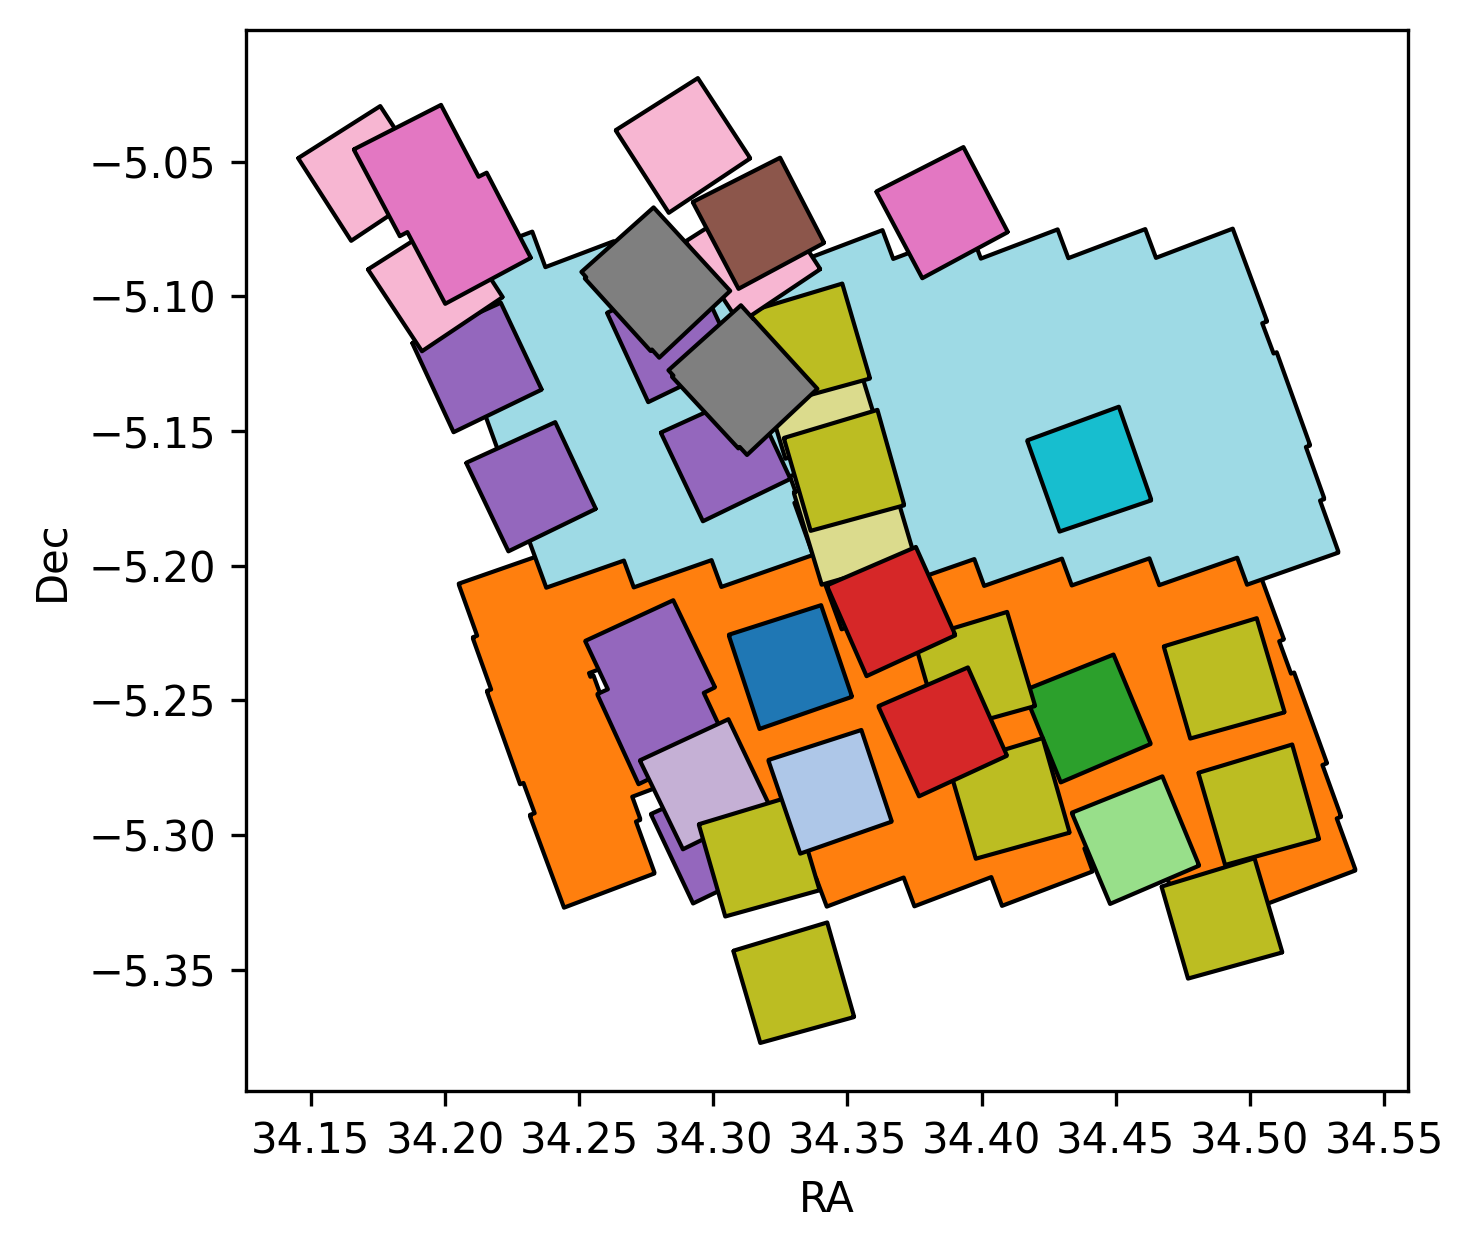

In [ ]:
field = 'uds-test'
filt = 'F444W'
data_dir = Path('../data')
drz_file = data_dir / f'{field}-{filt.lower()}_sci.fits'
csv_file = data_dir / f'{field}-{filt.lower()}_wcs.csv'

dpsf = DrizzlePSF(driz_image=str(drz_file), csv_file=str(csv_file))
footprints = {k: v for i, (k, v) in enumerate(dpsf.footprint.items()) if i>100 and i<115}
prm = PSFRegionMap.from_footprints(footprints, buffer_tol=1.0/3600, area_factor=300)

fig, ax = plt.subplots()
prm.regions.plot(column='psf_key', ax=ax, edgecolor='k', cmap='tab20')
ax.set_xlabel('RA'); ax.set_ylabel('Dec')
fig.show()

prma = prm.group_by_pa(pa_tol=1.0, wcs=dpsf.wcs)
#prm.regions,prma.regions


## Create PSF cubes for both filters

In [ ]:
filters = ['F444W', 'F770W']
psf_cubes = {}
for filt in filters:
    drz_file = data_dir / f'{field}-{filt.lower()}_sci.fits'
    csv_file = data_dir / f'{field}-{filt.lower()}_wcs.csv'
    dpsf = DrizzlePSF(driz_image=str(drz_file), csv_file=str(csv_file))
    centroids = prm.regions.geometry.centroid
    cube = []
    for ra, dec in zip(centroids.x, centroids.y):
        cube.append(dpsf.get_psf(ra, dec, filt))
    cube = np.asarray(cube)
    fits.writeto(data_dir / f'{field}_{filt.lower()}_psf.fits', cube, overwrite=True)
    psf_cubes[filt] = cube


## Compute matching kernels

In [ ]:
cube_444 = psf_cubes['F444W']
cube_770 = psf_cubes['F770W']
kernels = []
for p444, p770 in zip(cube_444, cube_770):
    ker = PSF.from_array(p444).matching_kernel(PSF.from_array(p770))
    kernels.append(ker)
kernels = np.asarray(kernels)
fits.writeto(data_dir / f'{field}_kernel_f444w_to_f770w.fits', kernels, overwrite=True)


## Fast kernel recall

In [ ]:
i = 1
ra, dec = prm.regions.loc[i].geometry.centroid.xy
psf_key = prm.regions.loc[i].psf_key
print(psf_key,ra[0],dec[0])
prm.lookup_key(ra[0], dec[0])

# psf_key is an index into the kernels array and matches the order of the regions
kernel_at_radec = kernels[psf_key]


